In [ ]:
!pip install cufflinks

In [51]:
import pandas as pd
import cufflinks as cf
from tensorflow.keras.models import Sequential
cf.go_offline()

# Meantemp

In [526]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv', index_col='date')

In [527]:
features = ['humidity', 'wind_speed', 'meanpressure']
target = 'meantemp'

In [528]:
def add_lag_features(df, target, lags):
    for lag in range(1, lags + 1):
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = 10
df_train = add_lag_features(df_train, target, lags)
df_test = add_lag_features(df_test, target, lags)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [529]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]] = scaler.fit_transform(
    df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]])
df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]] = scaler.transform(
    df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]])

scaler_target = MinMaxScaler(feature_range=(0, 1))
df_train[target] = scaler_target.fit_transform(df_train[[target]])
df_test[target] = scaler_target.transform(df_test[[target]])


In [530]:
def create_sequences_with_lag(data, target, time_steps=5, lags=10):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_with_lag(
    df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]].values, 
    df_train[target].values, 
    time_steps=5, 
    lags=lags
)
X_test, y_test = create_sequences_with_lag(
    df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]].values, 
    df_test[target].values, 
    time_steps=5, 
    lags=lags
)

print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1450, 5, 10)
y_train shape: (1450,)
X_test shape: (102, 5, 10)
y_test shape: (102,)


In [ ]:
model = Sequential()

model.add(GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization()) 
model.add(Dropout(0.2))          

model.add(GRU(128, activation='tanh', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(64, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), batch_size=32)

In [188]:
predictions = model.predict(X_test)
predicted_values = scaler_target.inverse_transform(predictions)
real_values = scaler_target.inverse_transform(y_test.reshape(-1, 1))


4/4 [==============================] - 1s 5ms/step


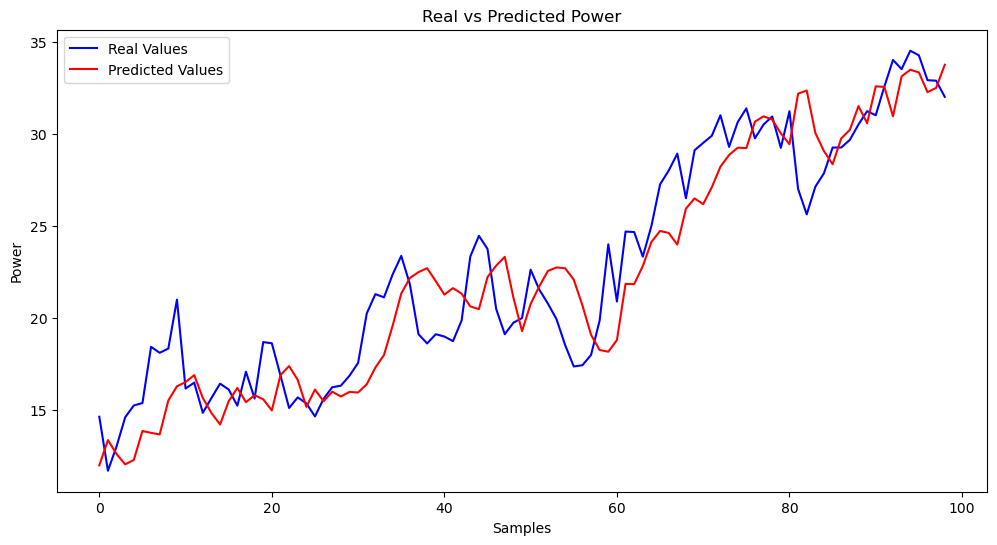

In [189]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(real_values, label='Real Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')

plt.title('Real vs Predicted Power')
plt.xlabel('Samples')
plt.ylabel('Power')
plt.legend()

plt.show()

In [190]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 2.0001682058298216


# Humidity

In [576]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv', index_col='date')

In [577]:
features = ['meantemp', 'wind_speed', 'meanpressure']
target = 'humidity'

In [578]:
def add_lag_features(df, target, lags):
    for lag in range(1, lags + 1):
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = 7
df_train = add_lag_features(df_train, target, lags)
df_test = add_lag_features(df_test, target, lags)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [579]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]] = scaler.fit_transform(
    df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]])
df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]] = scaler.transform(
    df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]])

scaler_target = MinMaxScaler(feature_range=(0, 1))
df_train[target] = scaler_target.fit_transform(df_train[[target]])
df_test[target] = scaler_target.transform(df_test[[target]])


In [580]:
def create_sequences_with_lag(data, target, time_steps=4, lags=5):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_with_lag(
    df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]].values, 
    df_train[target].values, 
    time_steps=5, 
    lags=lags
)
X_test, y_test = create_sequences_with_lag(
    df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]].values, 
    df_test[target].values, 
    time_steps=5, 
    lags=lags
)

print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1450, 5, 10)
y_train shape: (1450,)
X_test shape: (102, 5, 10)
y_test shape: (102,)


In [ ]:
model = Sequential()

model.add(GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization()) 
model.add(Dropout(0.2))          

model.add(GRU(128, activation='tanh', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(64, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=32)

In [212]:
predictions = model.predict(X_test)
predicted_values = scaler_target.inverse_transform(predictions)
real_values = scaler_target.inverse_transform(y_test.reshape(-1, 1))

4/4 [==============================] - 1s 5ms/step


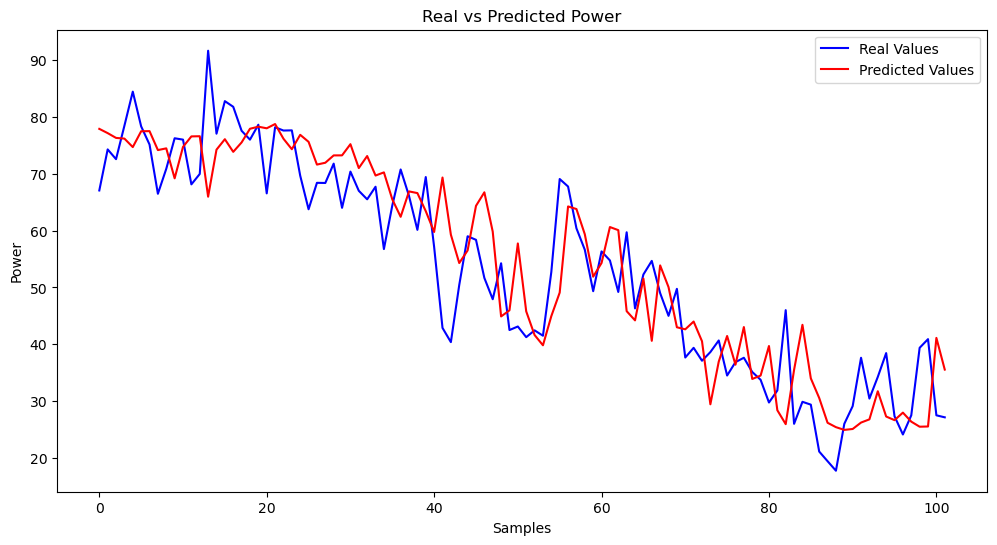

In [213]:
plt.figure(figsize=(12, 6))

plt.plot(real_values, label='Real Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')

plt.title('Real vs Predicted Power')
plt.xlabel('Samples')
plt.ylabel('Power')
plt.legend()

plt.show()

In [214]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 6.5391996635033705


# Wind Speed

In [602]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv', index_col='date')

In [603]:
features = ['meantemp', 'humidity', 'meanpressure']
target = 'wind_speed'

In [604]:
def add_lag_features(df, target, lags):
    for lag in range(1, lags + 1):
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = 7
df_train = add_lag_features(df_train, target, lags)
df_test = add_lag_features(df_test, target, lags)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [597]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]] = scaler.fit_transform(
    df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]])
df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]] = scaler.transform(
    df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]])

scaler_target = MinMaxScaler(feature_range=(0, 1))
df_train[target] = scaler_target.fit_transform(df_train[[target]])
df_test[target] = scaler_target.transform(df_test[[target]])


In [598]:
def create_sequences_with_lag(data, target, time_steps=7, lags=7):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_with_lag(
    df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]].values, 
    df_train[target].values, 
    time_steps=7, 
    lags=lags
)
X_test, y_test = create_sequences_with_lag(
    df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]].values, 
    df_test[target].values, 
    time_steps=7, 
    lags=lags
)

print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1455, 5, 5)
y_train shape: (1455,)
X_test shape: (107, 5, 5)
y_test shape: (107,)


In [ ]:
model = Sequential()

model.add(GRU(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization()) 
model.add(Dropout(0.2))          

model.add(GRU(128, activation='tanh', return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(64, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=32)

In [268]:
predictions = model.predict(X_test)
predicted_values = scaler_target.inverse_transform(predictions)
real_values = scaler_target.inverse_transform(y_test.reshape(-1, 1))

4/4 [==============================] - 1s 5ms/step


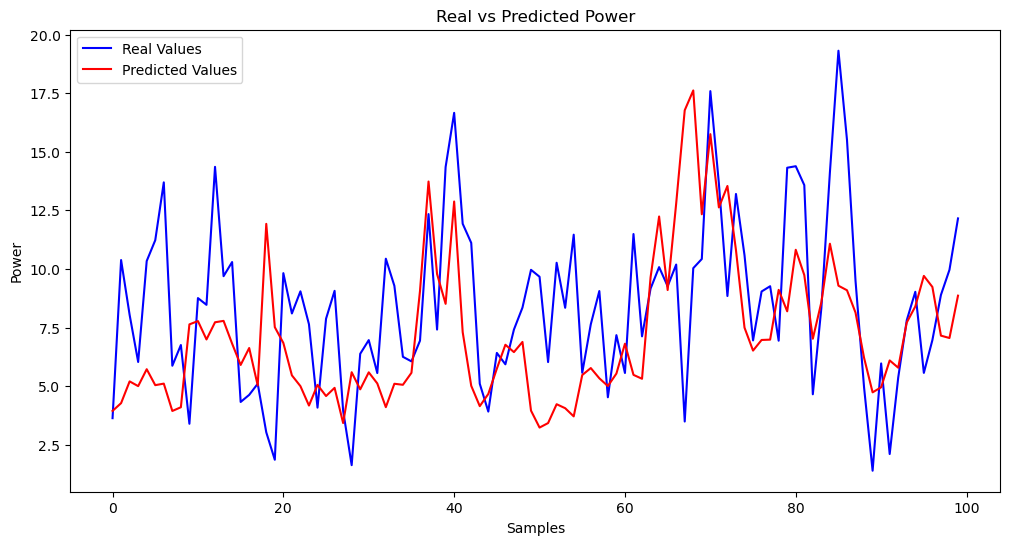

In [269]:
plt.figure(figsize=(12, 6))

plt.plot(real_values, label='Real Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')

plt.title('Real vs Predicted Power')
plt.xlabel('Samples')
plt.ylabel('Power')
plt.legend()

plt.show()

In [270]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 3.04963706911181


# Mean Pressure

In [626]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv', index_col='date')

In [627]:
df_test= df_test[2:114]

In [628]:
features = ['meantemp', 'humidity', 'wind_speed']
target = 'meanpressure'

In [614]:
def add_lag_features(df, target, lags):
    for lag in range(1, lags + 1):
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

lags = 3
df_train = add_lag_features(df_train, target, lags)
df_test = add_lag_features(df_test, target, lags)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [630]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]] = scaler.fit_transform(
    df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]])
df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]] = scaler.transform(
    df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]])

scaler_target = MinMaxScaler(feature_range=(0, 1))
df_train[target] = scaler_target.fit_transform(df_train[[target]])
df_test[target] = scaler_target.transform(df_test[[target]])


In [616]:
def create_sequences_with_lag(data, target, time_steps=3, lags=3):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_with_lag(
    df_train[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]].values, 
    df_train[target].values, 
    time_steps=3, 
    lags=lags
)
X_test, y_test = create_sequences_with_lag(
    df_test[features + [f'{target}_lag_{i}' for i in range(1, lags + 1)]].values, 
    df_test[target].values, 
    time_steps=3, 
    lags=lags
)

print("X_train shape:", X_train.shape)  
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1453, 3, 9)
y_train shape: (1453,)
X_test shape: (103, 3, 9)
y_test shape: (103,)


In [ ]:
model = Sequential()

# Входной слой GRU
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

# Дополнительные слои (если необходимо)
model.add(GRU(50, return_sequences=True))
model.add(GRU(50))

# Выходной слой
model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=16)

In [504]:
predictions = model.predict(X_test)
predicted_values = scaler_target.inverse_transform(predictions)
real_values = scaler_target.inverse_transform(y_test.reshape(-1, 1))

4/4 [==============================] - 0s 3ms/step


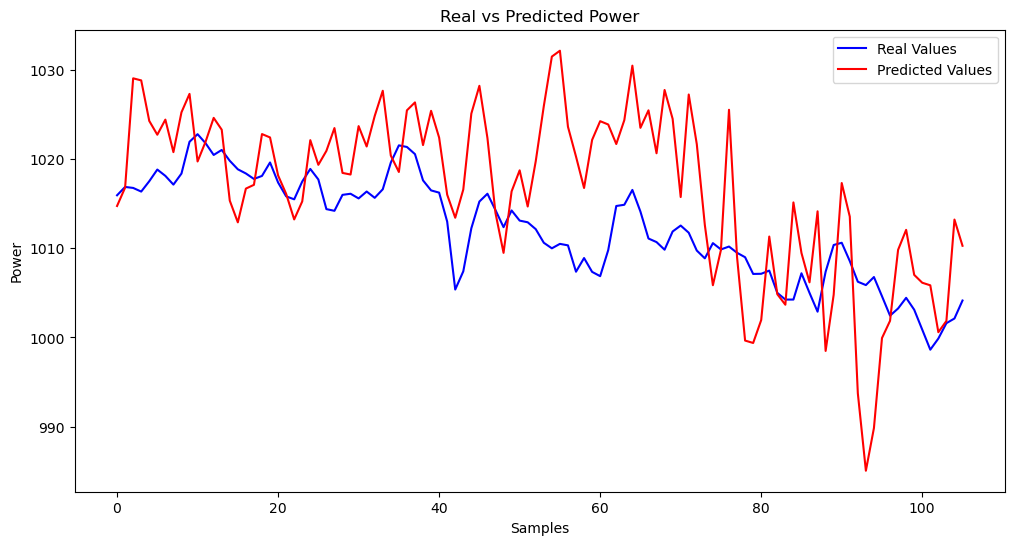

In [505]:
plt.figure(figsize=(12, 6))

plt.plot(real_values, label='Real Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')

plt.title('Real vs Predicted Power')
plt.xlabel('Samples')
plt.ylabel('Power')
plt.legend()

plt.show()

In [506]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 6.890525843175139


# Attention

In [521]:
class AttentionMechanism(Layer):
    def __init__(self, return_sequences=True):
        super(AttentionMechanism, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return tf.reduce_sum(output, axis=1)

In [ ]:
#meantemp

In [ ]:
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(AttentionMechanism(return_sequences=True))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

In [532]:
predictions = model.predict(X_test)
predicted_values = scaler_target.inverse_transform(predictions)
real_values = scaler_target.inverse_transform(y_test.reshape(-1, 1))


4/4 [==============================] - 0s 2ms/step


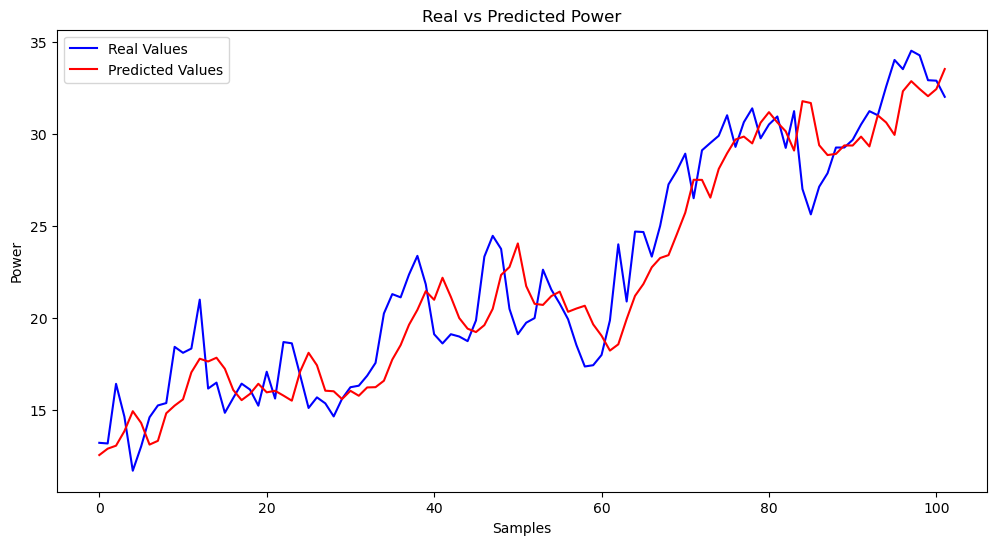

In [533]:
plt.figure(figsize=(12, 6))

plt.plot(real_values, label='Real Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')

plt.title('Real vs Predicted Power')
plt.xlabel('Samples')
plt.ylabel('Power')
plt.legend()

plt.show()

In [534]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 1.7728797220244552


In [ ]:
# humidity

In [ ]:
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(AttentionMechanism(return_sequences=True))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_data=(X_test, y_test))

In [582]:
predictions = model.predict(X_test)
predicted_values = scaler_target.inverse_transform(predictions)
real_values = scaler_target.inverse_transform(y_test.reshape(-1, 1))


4/4 [==============================] - 0s 3ms/step


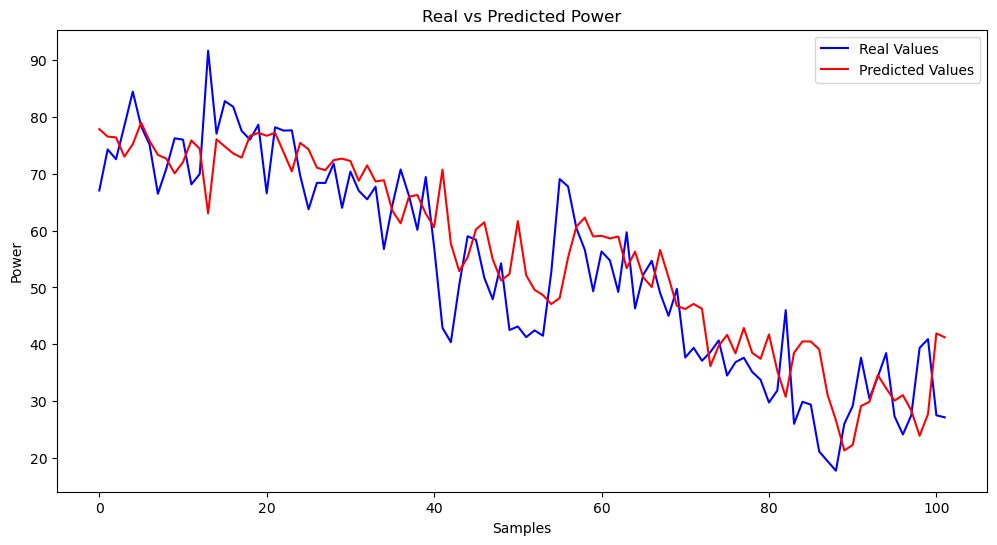

In [583]:
plt.figure(figsize=(12, 6))

plt.plot(real_values, label='Real Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')

plt.title('Real vs Predicted Power')
plt.xlabel('Samples')
plt.ylabel('Power')
plt.legend()

plt.show()

In [584]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 6.888365427180345


In [ ]:
# wind_speed

In [ ]:
model = Sequential()

model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(AttentionMechanism(return_sequences=True))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=70, batch_size=16, validation_data=(X_test, y_test))

In [608]:
predictions = model.predict(X_test)
predicted_values = scaler_target.inverse_transform(predictions)
real_values = scaler_target.inverse_transform(y_test.reshape(-1, 1))


4/4 [==============================] - 0s 4ms/step


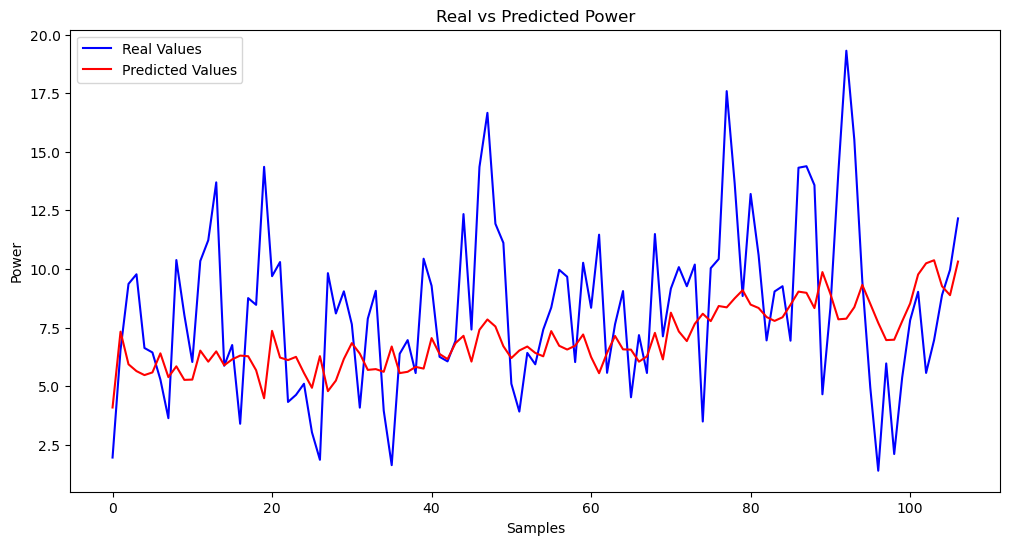

In [609]:
plt.figure(figsize=(12, 6))

plt.plot(real_values, label='Real Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')

plt.title('Real vs Predicted Power')
plt.xlabel('Samples')
plt.ylabel('Power')
plt.legend()

plt.show()

In [610]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 2.815977939181204


In [ ]:
# meanpressure

In [632]:
model = Sequential()

model.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(AttentionMechanism(return_sequences=True))

model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/70
46/46 [==============================] - 4s 17ms/step - loss: 0.0017 - val_loss: 4.7640e-05
Epoch 2/70
46/46 [==============================] - 0s 7ms/step - loss: 8.2147e-04 - val_loss: 1.2797e-05
Epoch 3/70
46/46 [==============================] - 0s 6ms/step - loss: 7.4082e-04 - val_loss: 9.1692e-06
Epoch 4/70
46/46 [==============================] - 0s 6ms/step - loss: 6.8351e-04 - val_loss: 1.0072e-05
Epoch 5/70
46/46 [==============================] - 0s 6ms/step - loss: 6.8032e-04 - val_loss: 9.3769e-05
Epoch 6/70
46/46 [==============================] - 0s 6ms/step - loss: 7.0727e-04 - val_loss: 1.2479e-06
Epoch 7/70
46/46 [==============================] - 0s 6ms/step - loss: 6.8318e-04 - val_loss: 2.4955e-05
Epoch 8/70
46/46 [==============================] - 0s 6ms/step - loss: 6.6502e-04 - val_loss: 5.7964e-05
Epoch 9/70
46/46 [==============================] - 0s 6ms/step - loss: 6.5787e-04 - val_loss: 4.3966e-06
Epoch 10/70
46/46 [==============================

In [633]:
predictions = model.predict(X_test)
predicted_values = scaler_target.inverse_transform(predictions)
real_values = scaler_target.inverse_transform(y_test.reshape(-1, 1))

4/4 [==============================] - 0s 3ms/step


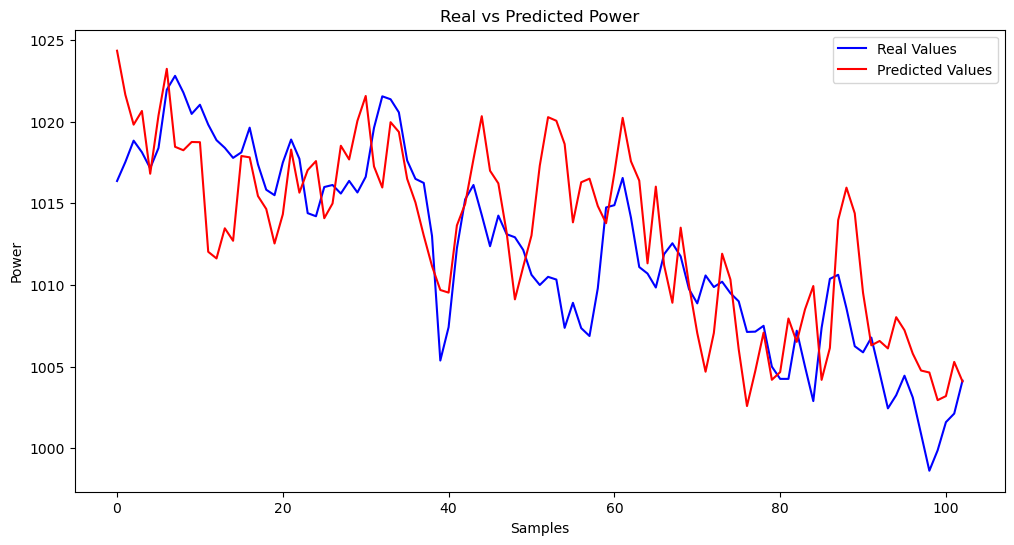

In [634]:
plt.figure(figsize=(12, 6))

plt.plot(real_values, label='Real Values', color='blue')
plt.plot(predicted_values, label='Predicted Values', color='red')

plt.title('Real vs Predicted Power')
plt.xlabel('Samples')
plt.ylabel('Power')
plt.legend()

plt.show()

In [635]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 3.2948351837886025


# Total

In [ ]:
data = {
    'Model': ['GRU', 'Gru with AttentionMechanism'],
    'MAPE meantemp': [mape_rnn_meantemp, mape_rnn_att_meantemp],
    'MAPE humidity': [mape_rnn_humidity, mape_rnn_att_humidity],
    'MAPE wind_speed': [mape_rnn_wind_speed, mape_rnn_att_wind_speed],
    'MAPE meanpressure': [mape_rnn_meanpressure, mape_rnn_att_meanpressure],
    'MAE meantemp': [mae_rnn_meantemp, mae_rnn_att_meantemp],
    'MAE humidity': [mae_rnn_humidity, mae_rnn_att_humidity],
    'MAE wind_speed': [mae_rnn_wind_speed, mae_rnn_att_wind_speed],
    'MAE meanpressure': [mae_rnn_meanpressure, mae_rnn_att_meanpressure]
}

models = pd.DataFrame(data)
models